In [28]:
%config StoreMagics.autorestore = True
%reset -f
# %store -z
%store -r
%whos

Variable           Type              Data/Info
----------------------------------------------
dvMathcalP         LinearIOSystem    <LinearIOSystem>: sys[3]\<...>[[0. 0.]\n     [0. 0.]]\n
extMathcalP        LinearIOSystem    <LinearIOSystem>: sys[2]\<...> [0. 0.]\n     [0. 0.]]\n
fullOrder          int               60
hsvDvMathcalP      ndarray           60: 60 elems, type `float64`, 480 bytes
hsvExtMathcalP     ndarray           60: 60 elems, type `float64`, 480 bytes
mathcalC           StateSpace        A = [[ -10. -225.]\n     <...>10. -0.]]\n\nD = [[0.]]\n
mathcalP_cb        LinearIOSystem    <LinearIOSystem>: sys[2]\<...>[[0. 0.]\n     [0. 0.]]\n
reducOrder         int               5
truncDvMathcalP    LinearIOSystem    <LinearIOSystem>: sys[5]\<...>[[0. 0.]\n     [0. 0.]]\n
truncExtMathcalP   LinearIOSystem    <LinearIOSystem>: sys[4]\<...> [0. 0.]\n     [0. 0.]]\n


In [29]:
import numpy
import sympy
import scipy
import control
import matplotlib as mpl
import matplotlib.pyplot as plt
import time

import multiprocessing
from joblib import Parallel, delayed  
from tqdm.notebook import tqdm

from custom_utils import ControlUtils
from custom_utils import ODEUtils

from IPython.display import display
from IPython.display import Math
from IPython.display import Latex
from IPython.display import HTML

numpy.set_printoptions(precision=3)
sympy.init_printing(use_latex='mathjax', use_unicode=True)
sympy.init_printing()
plt.rcParams.update({ "text.usetex": True, "font.family": "Helvetica", "axes.titley": 1.0 } )
%matplotlib inline

In [30]:
s = control.TransferFunction.s
def smallgain_condition(Tsam,mathcalC,extMathcalP,truncExtMathcalP):
        # Norm operator Delta
        normInfDelta = 2*Tsam/numpy.pi
        # Discretizing controller and computing norm of widetildeMathcalCs
        overlineMathcalC = control.sample_system(mathcalC, Tsam, 'zoh')
        mathcalCPrime = control.ss(mathcalC.A,mathcalC.B,mathcalC.C,numpy.zeros(mathcalC.D.shape))
        tfMathcalCPrime = control.ss2tf(mathcalCPrime)
        gamma_dv_tildew = normInfDelta * ControlUtils.hinfnorm(mathcalC) \
                                + normInfDelta * ControlUtils.hinfnorm(s * tfMathcalCPrime) * normInfDelta \
                                + ControlUtils.hinfnorm(tfMathcalCPrime) * normInfDelta 
        #######################################################################                        
        # Creating closed-loop
        # Controller matrices
        Ac = mathcalC.A
        Bv = mathcalC.B
        Cw = mathcalC.C
        Dw = mathcalC.D
        #######################################################################
        # FOM extended plant
        Ap = extMathcalP.A
        Bw = extMathcalP.B[:,0:1]
        Bu = extMathcalP.B[:,1:2]
        Cv = extMathcalP.C[0:1,:]
        Cy = extMathcalP.C[-1:,:]
        Dv = extMathcalP.D[0:1,:]
        Dy = extMathcalP.D[-1:,:]
        # Closed-loop with FOM Extended Plant
        extAcl = numpy.row_stack( [ numpy.column_stack( [ Ap + Bw@Dw@Cv, Bw@Cw ] ),
                                        numpy.column_stack( [ Bv@Cv, Ac ] )
                                        ] )
        extBcl = numpy.row_stack( [ numpy.column_stack([Bw, Bu]),
                                        numpy.column_stack( [ numpy.zeros( (Ac.shape[0],Bw.shape[1]) ), numpy.zeros( (Ac.shape[0],Bu.shape[1]) ) ] )
                                        ] )
        extCcl = numpy.row_stack( [ numpy.column_stack( [ Cv, numpy.zeros( (Cv.shape[0],Ac.shape[0]) ) ] ),
                                        numpy.column_stack( [ Cv@Ap + Cv@Bw@Dw@Cv, Cv@Bw@Cw ] ),
                                        numpy.column_stack( [ Cy, numpy.zeros( (Cy.shape[0],Ac.shape[0]) ) ] )
                                        ] )
        extDcl = numpy.row_stack( [ numpy.column_stack( [ numpy.zeros( (Cv.shape[0],Bw.shape[1]) ), numpy.zeros( (Cv.shape[0],Bu.shape[1]) ) ] ),
                                        numpy.column_stack( [ Cv@Bw , Cv@Bu] ),
                                        numpy.column_stack( [ numpy.zeros( (Cy.shape[0],Bw.shape[1]) ), numpy.zeros( (Cy.shape[0],Bu.shape[1]) ) ] )
                                        ] )
        extMathcalPcl = control.ss(extAcl,extBcl,extCcl,extDcl)
        #######################################################################
        # ROM extended plant
        truncExtAp = truncExtMathcalP.A
        truncExtBw = truncExtMathcalP.B[:,0:1]
        truncExtBu = truncExtMathcalP.B[:,1:2]
        truncExtCv = truncExtMathcalP.C[0:1,:]
        truncExtCy = truncExtMathcalP.C[-1:,:]
        truncExtDv = truncExtMathcalP.D[0:1,:]
        truncExtDy = truncExtMathcalP.D[-1:,:]
        # Closed-loop with ROM Extended Plant
        truncExtAcl = numpy.row_stack( [ numpy.column_stack( [ truncExtAp + truncExtBw@Dw@truncExtCv, truncExtBw@Cw ] ),
                                        numpy.column_stack( [ Bv@truncExtCv, Ac ] )
                                        ] )
        truncExtBcl = numpy.row_stack( [ numpy.column_stack([truncExtBw, truncExtBu]),
                                        numpy.column_stack( [ numpy.zeros( (Ac.shape[0],truncExtBw.shape[1]) ), numpy.zeros( (Ac.shape[0],truncExtBu.shape[1]) ) ] )
                                        ] )
        truncExtCcl = numpy.row_stack( [ numpy.column_stack( [ truncExtCv, numpy.zeros( (truncExtCv.shape[0],Ac.shape[0]) ) ] ),
                                        numpy.column_stack( [ truncExtCv@truncExtAp + truncExtCv@truncExtBw@Dw@truncExtCv, truncExtCv@truncExtBw@Cw ] ),
                                        numpy.column_stack( [ truncExtCy, numpy.zeros( (truncExtCy.shape[0],Ac.shape[0]) ) ] )
                                        ] )
        truncExtDcl = numpy.row_stack( [ numpy.column_stack( [ numpy.zeros( (truncExtCv.shape[0],truncExtBw.shape[1]) ), numpy.zeros( (truncExtCv.shape[0],truncExtBu.shape[1]) ) ] ),
                                        numpy.column_stack( [ truncExtCv@truncExtBw , truncExtCv@truncExtBu] ),
                                        numpy.column_stack( [ numpy.zeros( (truncExtCy.shape[0],truncExtBw.shape[1]) ), numpy.zeros( (truncExtCy.shape[0],truncExtBu.shape[1]) ) ] )
                                        ] )
        truncExtMathcalPcl = control.ss(truncExtAcl,truncExtBcl,truncExtCcl,truncExtDcl)
        #######################################################################
        approxErrorExtMathcalPcl = extMathcalPcl-truncExtMathcalPcl
        #######################################################################
        # Computing norms for small-gain stability condition
        gamma_tildew_dv = ControlUtils.hinfnorm(extMathcalPcl[1,0])
        epsilon_tildew_dv = ControlUtils.hinfnorm(approxErrorExtMathcalPcl[1,0])
        return (gamma_tildew_dv,epsilon_tildew_dv,gamma_dv_tildew,extMathcalPcl,truncExtMathcalPcl,approxErrorExtMathcalPcl)

In [34]:
# Notch Filter
sigma = 10
wn_lims = [50, 150]
wn_steps = 50
wns = numpy.linspace(wn_lims[0],wn_lims[1],wn_steps)

samp_lim = [0.20,0.3]
samp_steps = 50
samplings = numpy.linspace(samp_lim[0],samp_lim[1],samp_steps)

idx_args_list = []
for i in range(samp_steps):
    for j in range(wn_steps):
        Tsam = samplings[i]
        wn = wns[j]
        num = [1,0,wn**2]
        den = [1,sigma,wn**2]
        mathcalC = control.tf2ss(num,den)
        idx_args_list.append([(i,j),(Tsam,mathcalC,extMathcalP,truncExtMathcalP)])
        
num_cores = multiprocessing.cpu_count()
idx_results_list = Parallel(n_jobs=num_cores)\
                        (\
                            delayed( lambda idx,args: (idx, smallgain_condition(*args)) )( idx_args_list[k][0], idx_args_list[k][1] )\
                                for k in tqdm(range(len(idx_args_list)), position=0)\
                        )

  0%|          | 0/2500 [00:00<?, ?it/s]

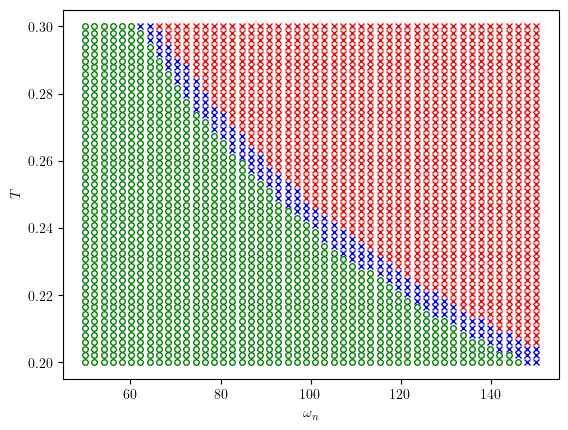

In [35]:
for k in range(len(idx_results_list)):
    (i,j),(gamma_tildew_dv,epsilon_tildew_dv,gamma_dv_tildew,extMathcalPcl,truncExtMathcalPcl,approxErrorExtMathcalPcl) = idx_results_list[k]
    small_gain_cond_FOM = gamma_tildew_dv*gamma_dv_tildew
    small_gain_cond_ROM = (gamma_tildew_dv+epsilon_tildew_dv)*gamma_dv_tildew
    Tsam = samplings[i]
    wn = wns[j]
    if(small_gain_cond_FOM>=1):
        plt.plot(wn, Tsam, marker="x", markersize=4, markerfacecolor='r', markeredgecolor='r')
    elif(small_gain_cond_ROM>=1):
        plt.plot(wn, Tsam, marker="x", markersize=4, markerfacecolor='b', markeredgecolor='b')
    else:
        plt.plot(wn, Tsam, marker="o", markersize=4, markerfacecolor='none', markeredgecolor='g')
        
plt.ylabel('$T$')
plt.xlabel('$\\omega_n$')
plt.show()